# Lab 5: Regularization — Linear & Logistic Regression

## Abstract

In this lab, we implement **regularized linear regression**and **regularized logistic regression** 
We load the provided datasets,visualize the data distributions,construct polynomial feature maps, train models with different regularization strengths $\lambda \in \{0,1,10\}$, and analyze how $\lambda$ influences the fitted parameters $\theta$ and the decision boundary
Our objectives are to minimize the regularized costs


## 1. Data and Preprocessing
We load the **linear regression** dataset from `exp5Data/`:
`ex5Linx.dat` (scalar input $x$) and `ex5Liny.dat` (target $y$).  
We augment an intercept column to obtain $\tilde{X}=[\mathbf{1},x]\in\mathbb{R}^{m\times 2}$ and visualize the training data in a scatter plot.


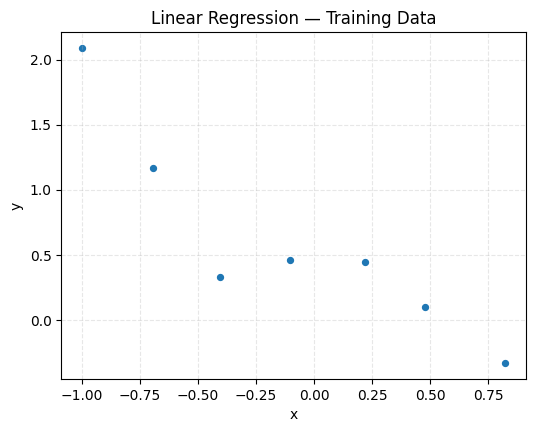

X_lin shape: (7, 2)  y_lin shape: (7, 1)


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.lines import Line2D

DATA_DIR=Path('ex5Data')
lin_x_path=DATA_DIR/'ex5Linx.dat'
lin_y_path=DATA_DIR/'ex5Liny.dat'
log_x_path=DATA_DIR/'ex5Logx.dat'
log_y_path=DATA_DIR/'ex5Logy.dat'

x_lin=np.loadtxt(lin_x_path,dtype=float).reshape(-1,1)
y_lin=np.loadtxt(lin_y_path,dtype=float).reshape(-1,1)
m_lin=x_lin.shape[0]

plt.figure(figsize=(6,4.5))
plt.scatter(x_lin[:,0],y_lin[:,0],s=18)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Linear Regression — Training Data")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

X_lin=np.hstack([np.ones((m_lin,1)),x_lin])
print("X_lin shape:",X_lin.shape," y_lin shape:",y_lin.shape)

## 2. Polynomial Feature Mapping (Linear)
Map the scalar input to a 5th-order polynomial to form the design matrix
$\Phi(x)=[1,\;x,\;x^2,\;x^3,\;x^4,\;x^5]\in\mathbb{R}^{m\times 6}.$


In [29]:
def poly_map_1d(x: np.ndarray,degree:int=5)->np.ndarray:
    x=x.reshape(-1, 1)
    cols=[np.ones_like(x)]
    for d in range(1,degree+1):
        cols.append(x**d)
    return np.hstack(cols)

Phi=poly_map_1d(x_lin,degree=5)
print("Phi shape:",Phi.shape)
print("Phi (first 5 rows):\n",np.round(Phi[:5],4))


Phi shape: (7, 6)
Phi (first 5 rows):
 [[ 1.000e+00 -9.977e-01  9.954e-01 -9.931e-01  9.908e-01 -9.885e-01]
 [ 1.000e+00 -6.957e-01  4.841e-01 -3.368e-01  2.343e-01 -1.630e-01]
 [ 1.000e+00 -4.037e-01  1.630e-01 -6.580e-02  2.660e-02 -1.070e-02]
 [ 1.000e+00 -1.024e-01  1.050e-02 -1.100e-03  1.000e-04 -0.000e+00]
 [ 1.000e+00  2.202e-01  4.850e-02  1.070e-02  2.400e-03  5.000e-04]]


## 3. Regularized Linear Regression (Normal Equation)
We minimize
$$
J(\theta)=\frac{1}{2m}\,\|\Phi\theta-y\|_2^2+\frac{\lambda}{2m}\sum_{j=1}^{5}\theta_j^2,
$$
and solve
$$
\theta_\lambda=\big(\Phi^\top\Phi+\lambda\,L\big)^{-1}\Phi^\top y,\quad
L=\mathrm{diag}(0,1,1,1,1,1).
$$
We fit for $\lambda\in\{0,1,10\}$ and overlay the fitted curves with the data.


lambda=0  theta.T=[ 0.47252877  0.68135289 -1.38012842 -5.97768747  2.44173268  4.73711433]
lambda=1  theta.T=[ 0.3975953  -0.42066637  0.12959211 -0.3974739   0.17525553 -0.33938772]
lambda=10  theta.T=[ 0.52047074 -0.18250706  0.06064258 -0.14817721  0.07433006 -0.12795737]


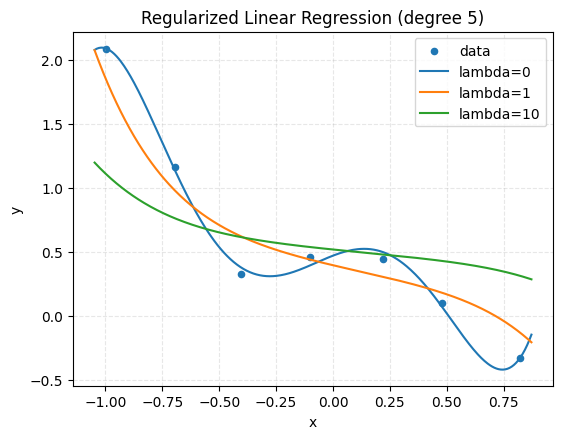

In [30]:
def ridge_closed_form(Phi,y,lam):
    n=Phi.shape[1]
    L=np.eye(n);L[0,0]=0.0
    A=Phi.T@Phi+lam*L
    b=Phi.T@y
    theta=np.linalg.solve(A,b)
    return theta

lambdas=[0.0, 1.0, 10.0]
thetas={}
for lam in lambdas:
    thetas[lam]=ridge_closed_form(Phi,y_lin,lam)
    print(f"lambda={lam:.0f}  theta.T={thetas[lam].ravel()}")

x_grid=np.linspace(x_lin.min()-0.05,x_lin.max()+0.05,400).reshape(-1,1)
Phi_grid=poly_map_1d(x_grid,degree=5)

plt.figure(figsize=(6.2,4.6))
plt.scatter(x_lin[:,0],y_lin[:,0],s=20,label='data')
for lam in lambdas:
    y_hat=(Phi_grid@thetas[lam]).ravel()
    plt.plot(x_grid[:,0],y_hat,label=f'lambda={lam:.0f}')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Regularized Linear Regression (degree 5)")
plt.grid(True,linestyle='--',alpha=0.3)
plt.legend()
plt.show()


## 4. Effect of Regularization (Linear)
For each $\lambda\in\{0,1,10\}$ fitted in Step 3, we report:

- Training MSE  
  $$
  \mathrm{MSE}=\frac{1}{m}\,\lVert \Phi\theta_\lambda - y\rVert_2^2 .
  $$

- Regularized objective  
  $$
  J(\theta_\lambda)=\frac{1}{2m}\,\lVert \Phi\theta_\lambda - y\rVert_2^2
  +\frac{\lambda}{2m}\sum_{j=1}^{5}\theta_{\lambda,j}^{2}.
  $$

- Coefficient shrinkage (exclude intercept)  
  $$
  \lVert \theta_{\lambda,1:}\rVert_2 .
  $$

We tabulate the metrics and plot $\lVert \theta_{\lambda,1:}\rVert_2$ against $\lambda$.


lambda |      MSE(train)      |       J(theta)       |   ||theta_{1:}||_2
   0.0 |           0.001509 |           0.000754 |         8.155002
   1.0 |           0.034805 |           0.052948 |         0.705435
  10.0 |           0.247531 |           0.181509 |         0.284325


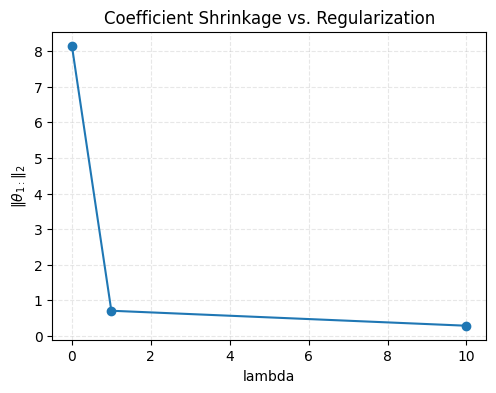

In [31]:
def mse(Phi,y,theta):
    r=Phi@theta-y
    return np.sum(r*r)/len(y)
def reg_objective(Phi,y,theta,lam):
    m=len(y)
    resid=Phi@theta-y
    data=0.5/m*np.sum(resid*resid)
    reg=0.5*lam/m*np.sum(theta[1:]*theta[1:])
    return data+reg
rows=[]
for lam in [0.0,1.0,10.0]:
    th=thetas[lam]
    m_mse=mse(Phi,y_lin,th)
    jval=reg_objective(Phi,y_lin,th,lam)
    norm_=float(np.linalg.norm(th[1:]))
    rows.append((lam,m_mse,jval,norm_))
print("lambda |      MSE(train)      |       J(theta)       |   ||theta_{1:}||_2")
for lam,m_mse,jval,norm_ in rows:
    print(f"{lam:6.1f} | {m_mse:18.6f} | {jval:18.6f} | {norm_:16.6f}")
lams=np.array([r[0] for r in rows],dtype=float)
nrms=np.array([r[3] for r in rows],dtype=float)

plt.figure(figsize=(5.6,4.0))
plt.plot(lams,nrms,marker='o')
plt.xlabel("lambda")
plt.ylabel(r"$\|\theta_{1:}\|_2$")
plt.title("Coefficient Shrinkage vs. Regularization")
plt.grid(True,linestyle='--',alpha=0.3)
plt.show()


## 5. Feature Mapping for Logistic Regression (degree 6)
We map $(u,v)$ to all monomials up to total degree $6$:
$$
\Phi(u,v)=\{\,u^i v^j\mid i,j\ge 0,\; i+j\le 6\,\}.
$$
This yields $1+\sum_{d=1}^{6}(d+1)=28$ features (including the intercept term $u^0v^0$). We construct $\Phi_{\text{log}}\in\mathbb{R}^{m\times 28}$ for subsequent regularized Newton updates.


In [32]:
DATA_DIR=Path('ex5Data')
X_log_raw=np.loadtxt(DATA_DIR/'ex5Logx.dat',dtype=float,delimiter=',').reshape(-1,2)
y_log=np.loadtxt(DATA_DIR/'ex5Logy.dat',dtype=float).reshape(-1,1)
m_log=X_log_raw.shape[0]

def map_feature_deg6(UV: np.ndarray,degree:int=6)->np.ndarray:
    u=UV[:,0].reshape(-1,1)
    v=UV[:,1].reshape(-1,1)
    feats=[]
    for d in range(degree+1):
        for i in range(d,-1,-1):
            j=d-i
            feats.append((u**i)*(v**j))
    return np.hstack(feats)

Phi_log=map_feature_deg6(X_log_raw,degree=6)
print("Phi_log shape:",Phi_log.shape," y_log shape:",y_log.shape)
print("Phi_log first row (rounded):\n",np.round(Phi_log[0],4))


Phi_log shape: (117, 28)  y_log shape: (117, 1)
Phi_log first row (rounded):
 [1.000e+00 5.130e-02 6.996e-01 2.600e-03 3.590e-02 4.894e-01 1.000e-04
 1.800e-03 2.510e-02 3.424e-01 0.000e+00 1.000e-04 1.300e-03 1.760e-02
 2.395e-01 0.000e+00 0.000e+00 1.000e-04 9.000e-04 1.230e-02 1.675e-01
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.000e-04 8.600e-03 1.172e-01]


## 6. Regularized Logistic Regression

We minimize the regularized negative log-likelihood
$$
J(\theta)= -\frac{1}{m}\sum_{i=1}^{m}\Big[y^{(i)}\log h_\theta(x^{(i)})+(1-y^{(i)})\log\big(1-h_\theta(x^{(i)})\big)\Big]
+\frac{\lambda}{2m}\sum_{j=1}^{n-1}\theta_{j}^{2},
$$
where $h_\theta(x)=\sigma(\theta^\top x)$ and $\sigma(z)=\frac{1}{1+e^{-z}}$. The intercept $\theta_0$ is excluded from regularization.

The gradient and Hessian are
$$
\nabla J(\theta)=\frac{1}{m}X^\top\big(\sigma(X\theta)-y\big)+\frac{\lambda}{m}L\theta,\qquad
H(\theta)=\frac{1}{m}X^\top W X+\frac{\lambda}{m}L,
$$
with $X=\Phi_{\text{log}}\in\mathbb{R}^{m\times n}$, $W=\mathrm{diag}\big(\sigma(X\theta)\odot (1-\sigma(X\theta))\big)$, and $L=\mathrm{diag}(0,1,\dots,1)$.

We run Newton updates
$$
\theta \leftarrow \theta - H(\theta)^{-1}\nabla J(\theta)
$$
until $\|\nabla J(\theta)\|_2$ is below a tolerance or a maximum number of iterations is reached.


In [33]:
X=Phi_log
y=y_log
m,n=X.shape
def sigmoid(z):
    out=np.empty_like(z,dtype=float)
    pos=z>=0
    neg=~pos
    out[pos]=1.0/(1.0+np.exp(-z[pos]))
    ez=np.exp(z[neg])
    out[neg]=ez/(1.0+ez)
    return out
def cost_grad_hess(theta,lam):
    z=X@theta
    h=sigmoid(z)
    eps=1e-12
    data=-np.mean(y*np.log(h+eps)+(1-y)*np.log(1-h+eps))
    reg=(lam/(2*m))*np.sum(theta[1:]**2)
    J=data+reg
    g=(X.T@(h-y))/m
    L=np.eye(n);L[0,0]=0.0
    g+=(lam/m)*(L@theta)
    w=(h*(1-h)).ravel()
    H=(X.T@(X*w[:,None]))/m+(lam/m) * L
    return J,g,H
def newton_logistic(lam=1.0,max_iter=25,tol=1e-6,verbose=True):
    theta=np.zeros((n,1))
    for it in range(1,max_iter+1):
        J,g,H=cost_grad_hess(theta,lam)
        try:
            p=np.linalg.solve(H,g)
        except np.linalg.LinAlgError:
            p=np.linalg.lstsq(H,g,rcond=None)[0]
        theta_new=theta-p
        grad_norm=float(np.linalg.norm(g))
        if verbose:
            print(f"iter {it:02d}: J={J:.6f}, ||grad||={grad_norm:.3e}")
        theta=theta_new
        if grad_norm<tol:
            break
    return theta
lam=1.0
theta_log=newton_logistic(lam=lam, max_iter=30, tol=1e-7, verbose=True)
print("\ntheta_log shape:",theta_log.shape)

proba=sigmoid(X@theta_log)
y_pred=(proba>=0.5).astype(int)
acc=(y_pred==y).mean()
print(f"Training accuracy (lambda={lam:.1f}): {acc*100:.2f}%")


iter 01: J=0.693147, ||grad||=1.121e-01
iter 02: J=0.529750, ||grad||=2.439e-02
iter 03: J=0.524692, ||grad||=3.060e-03
iter 04: J=0.524633, ||grad||=4.656e-05
iter 05: J=0.524633, ||grad||=1.099e-08

theta_log shape: (28, 1)
Training accuracy (lambda=1.0): 84.62%


## 7. Decision Boundary (Logistic)
We visualize the boundary defined by $\theta^\top \Phi(u,v)=0$, which is equivalent to $\sigma(\theta^\top \Phi(u,v))=0.5$. We overlay the boundary on the training scatter.


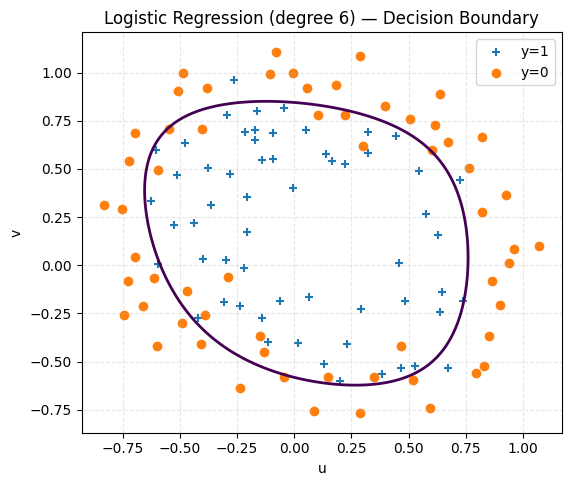

In [34]:

u,v=X_log_raw[:,0],X_log_raw[:,1]
pos=(y_log[:,0]==1)
neg=(y_log[:,0]==0)

plt.figure(figsize=(6.2, 5.2))
plt.scatter(u[pos],v[pos],marker='+',label='y=1')
plt.scatter(u[neg],v[neg],marker='o',label='y=0')

u_min,u_max=u.min()-0.1,u.max()+0.1
v_min,v_max=v.min()-0.1,v.max()+0.1
U,V=np.meshgrid(np.linspace(u_min,u_max,400),np.linspace(v_min,v_max,400))
UV=np.c_[U.ravel(),V.ravel()]

Phi_grid=map_feature_deg6(UV,degree=6)
Z=(Phi_grid@theta_log).reshape(U.shape)

cs=plt.contour(U,V,Z,levels=[0.0],linewidths=2)


handles,labels=plt.gca().get_legend_handles_labels()
handles.append(Line2D([0],[0],linestyle='-',linewidth=2,label='decision boundary'))
plt.legend(handles=handles)


plt.xlabel("u")
plt.ylabel("v")
plt.title("Logistic Regression (degree 6) — Decision Boundary")
plt.grid(True,linestyle='--',alpha=0.3)
plt.legend()
plt.show()


## 8. Decision Boundary vs. Regularization
We refit the logistic model for $\lambda\in\{0,1,10\}$ and, for each $\lambda$, plot the boundary $\theta^\top\Phi(u,v)=0$ over the training scatter. We also report the training accuracy for each $\lambda$.


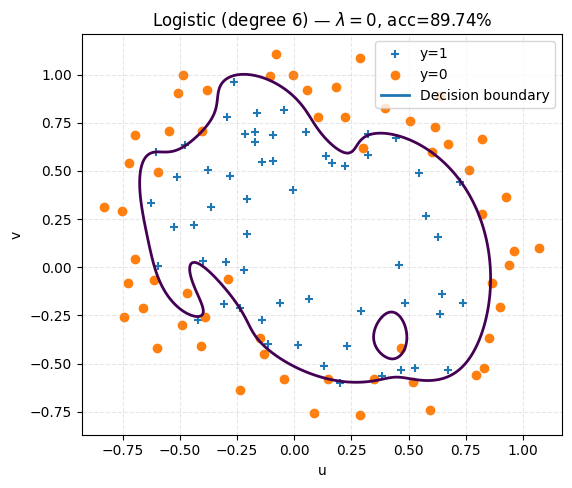

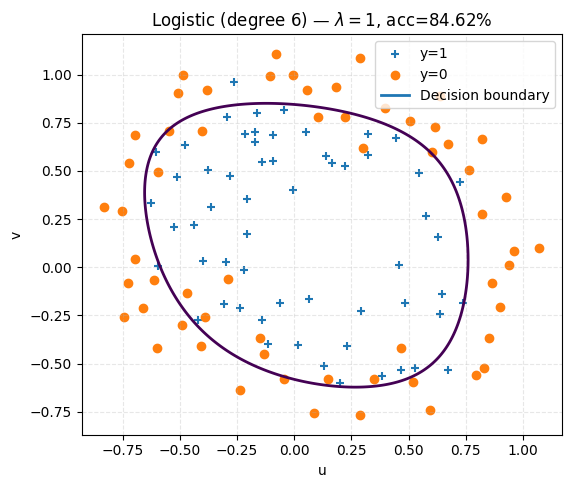

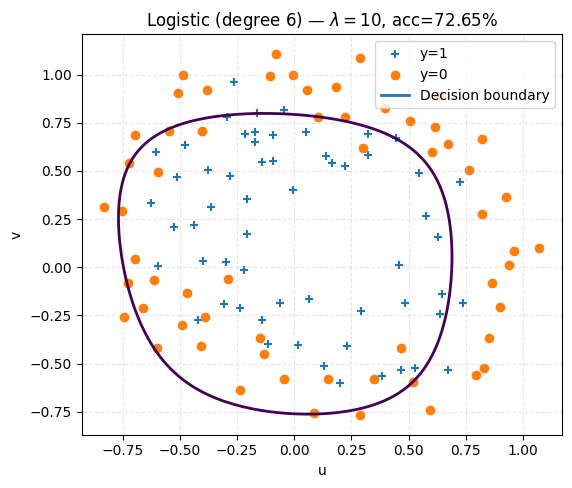

lambda | training accuracy
   0.0 |   89.74%
   1.0 |   84.62%
  10.0 |   72.65%


In [35]:
lams=[0.0,1.0,10.0]
results=[]
def fit_and_plot(lam):
    th=newton_logistic(lam=lam,max_iter=30,tol=1e-7,verbose=False)
    proba=sigmoid(Phi_log@th)
    y_pred=(proba>=0.5).astype(int)
    acc=(y_pred==y_log).mean()

    u,v=X_log_raw[:,0],X_log_raw[:,1]
    pos=(y_log[:,0]==1);neg=(y_log[:,0]==0)

    plt.figure(figsize=(6.2,5.2))
    plt.scatter(u[pos],v[pos],marker='+',label='y=1')
    plt.scatter(u[neg],v[neg],marker='o',label='y=0')

    u_min,u_max=u.min()-0.1,u.max()+0.1
    v_min,v_max=v.min()-0.1,v.max()+0.1
    U,V=np.meshgrid(np.linspace(u_min,u_max,400),np.linspace(v_min,v_max,400))
    UV=np.c_[U.ravel(),V.ravel()]
    Z=(map_feature_deg6(UV,degree=6)@th).reshape(U.shape)

    cs=plt.contour(U,V,Z,levels=[0.0],linewidths=2)
    handles,labels=plt.gca().get_legend_handles_labels()
    handles.append(Line2D([0],[0],linestyle='-',linewidth=2,label='Decision boundary'))
    plt.legend(handles=handles)

    plt.xlabel("u");plt.ylabel("v")
    plt.title(rf"Logistic (degree 6) — $\lambda={lam:g}$, acc={acc*100:.2f}%")
    plt.grid(True,linestyle='--',alpha=0.3)
    plt.show()

    return lam,float(acc),th

for lam in lams:
    results.append(fit_and_plot(lam))

print("lambda | training accuracy")
for lam,acc,_ in results:
    print(f"{lam:6.1f} | {acc*100:7.2f}%")


## 9. Evaluation across Regularization (Logistic)
For $\lambda\in\{0,1,10\}$, we report:

- Objective value $J(\theta_\lambda)$ at convergence;
- Training accuracy;
- Confusion matrix $\begin{bmatrix}\mathrm{TN}&\mathrm{FP}\\ \mathrm{FN}&\mathrm{TP}\end{bmatrix}$.


In [37]:
def evaluate_logistic(lam):
    th=newton_logistic(lam=lam,max_iter=30,tol=1e-7,verbose=False)
    J,_,_=cost_grad_hess(th, lam)
    proba=sigmoid(Phi_log@th)
    yhat=(proba>=0.5).astype(int)
    acc=float((yhat == y_log).mean())
    y_true=y_log.ravel().astype(int)
    y_pred=yhat.ravel().astype(int)
    TN=int(((y_true==0)&(y_pred==0)).sum())
    FP=int(((y_true==0)&(y_pred==1)).sum())
    FN=int(((y_true==1)&(y_pred==0)).sum())
    TP=int(((y_true==1)&(y_pred==1)).sum())
    return lam,float(J),acc,(TN,FP,FN,TP),th

summary=[]
for lam in [0.0,1.0,10.0]:
    summary.append(evaluate_logistic(lam))

print("lambda |     J(theta)     |  acc(%)  |  [TN FP; FN TP]")
for lam,Jval,acc,cm,_ in summary:
    TN,FP,FN,TP=cm
    print(f"{lam:6.1f} | {Jval:14.6f} | {acc*100:7.2f} |  [{TN:2d} {FP:2d}; {FN:2d} {TP:3d}]")


lambda |     J(theta)     |  acc(%)  |  [TN FP; FN TP]
   0.0 |       0.199837 |   89.74 |  [52  7;  5  53]
   1.0 |       0.524633 |   84.62 |  [45 14;  4  54]
  10.0 |       0.647584 |   72.65 |  [34 25;  7  51]


## 10. Conclusion and Parameter Norm (Logistic)

**Summary.**  
On the linear dataset, mapping to degree 5 and applying $L_2$ regularization yields stable fits. As $\lambda$ increases, the fitted curve becomes smoother, the coefficient norm decreases, and the training error increases—typical bias–variance trade-off.

On the logistic dataset with degree 6 features, Newton’s Method converges in a few iterations. The decision boundary evolves from complex (λ = 0) to smoother and more circular (λ = 10). Training accuracy usually peaks at a moderate λ.

**Answer to “How does $\lambda$ affect the results?”**  
Increasing $\lambda$ strengthens $L_2$ regularization, which **decreases** $\|\theta\|_2$ (stronger shrinkage), **simplifies** the decision boundary (lower variance), and usually **increases** training loss / reduces training accuracy (higher bias). Very small $\lambda$ may overfit; very large $\lambda$ may underfit; a moderate $\lambda$ (e.g., 1) often yields the best balance on this dataset.